# Generating Experimental Data

First, let's import tapsolver

In [1]:
from tapsolver import *

Our initial goal is to generate the TAPobject, which will consist of the reactor, gasses and adspecies, and mechanism. First, the reactor can be specified with

In [2]:
new_reactor = reactor()

## Additional options that may be necessary
# new_reactor.zone_lengths = {0:0.5,1:,0.1,2:0.5}
# new_reactor.zone_voids = {0:0.4,1:0.4,2:0.4}
# new_reactor.reactor_radius = 0.19

Additional parameters are specified, but we will be using the default parameters for the examples. Next, we need to define the reactor species object

In [3]:
species = reactor_species()

## Additional options that may be necessary
#species.inert_diffusion = 25.04
#species.catalyst_diffusion = 25.04
#species.reference_temperature = 700
#species.reference_mass = 40
#species.temperature = 833
#species.advection = 0

Now that the object that will contain all reactive and inert gasses, as well as adspecies, has been defined, we can begin adding them

In [4]:
# Define the gasses
CO = define_gas()
O2 = define_gas()
CO2 = define_gas()

CO.mass = 28
CO.intensity = 1
CO.noise = 0.0
CO.sigma = 0.0
CO.delay = 0.1

O2.mass = 32
O2.intensity = 1
O2.noise = 0.0

CO2.mass = 44
CO2.intensity = 0
CO2.noise = 0.0

species.add_gas('CO',CO)
species.add_gas('O2',O2)
species.add_gas('CO2',CO2)

Last of the gasses, the inert gas is included in the system

In [5]:
Ar = define_gas()

Ar.mass = 40
Ar.intensity = 1
Ar.noise = 0.0

species.add_inert_gas('Ar',Ar)

Next, we add our surface species, which will be in the catalyst zone

In [6]:
s = define_adspecies()
s.concentration = 0
species.add_adspecies('CO*',s)

s = define_adspecies()
s.concentration = 0
species.add_adspecies('O*',s)

s = define_adspecies()
s.concentration = 100
species.add_adspecies('*',s)

Now that the adspecies and gasses have been defined, we can begin defining the elementary processes and the rate constants. First we make our mechanism object

In [7]:
mech = mechanism()

Now we can add the processes to the mechanism object with

In [8]:
mech.elementary_processes[0] = elementary_process('CO + * <-> CO*')
mech.elementary_processes[0].forward.k = 1
mech.elementary_processes[0].backward.k = 1

mech.elementary_processes[1] = elementary_process('O2 + 2* <-> 2O*')
mech.elementary_processes[1].forward.k = 1
mech.elementary_processes[1].backward.k = 1

mech.elementary_processes[2] = elementary_process('CO* + O* <-> CO2 + 2*')
mech.elementary_processes[2].forward.k = 1
mech.elementary_processes[2].backward.k = 0

The last step is to actually generate the mechanism object with all relevant processes and parameters

In [9]:
for j in mech.elementary_processes:
	mech.elementary_processes[j].forward.use = 'k'
	try:
		mech.elementary_processes[j].backward.use = 'k'
	except:
		pass

mechanism_constructor(mech)

Finally, we will define the TAPobject and add all of the components we just generated

In [10]:
simulation = TAPobject()
simulation.reactor = new_reactor
simulation.reactor_species = species
simulation.mechanism = mech

simulation.output_name = 'co_oxidation_example'

Now we can ran a forward simulation with the forward_problem function

In [12]:
#simulation.reactor_species.gasses['CO'].intensity = 2
#simulation.reactor_species.gasses['CO'].delay = 0.0
#simulation.reactor_species.gasses['CO'].noise = 0.1
#simulation.reactor_species.gasses['O2'].noise = 0.1
#simulation.reactor_species.gasses['CO2'].noise = 0.1
#simulation.reactor_species.inert_gasses['Ar'].noise = 0.1

forward_problem(pulse_time=1,pulse_number=1,TAPobject_data_original=simulation)
flux_graph(simulation)


New Catalyst Fraction = 0.01
Old Catalyst Fraction = 0.009900990099009875
Change = 1.0%

Pulse #: 0
Percent: [------------------->] 99.9%Completed in: 40.965 seconds
Pulse #: 1
Percent: [------------------->] 99.9%Completed in: 40.201 seconds
Pulse #: 2
Percent: [------------------> ] 93.0%

KeyboardInterrupt: 

We can also run a series of pulses ('state altering experiment')

In [27]:
forward_problem(pulse_time=1,pulse_number=3,TAPobject_data_original=simulation)


New Catalyst Fraction = 0.01
Old Catalyst Fraction = 0.009900990099009875
Change = 1.0%

Pulse #: 0
Percent: [------------------->] 99.9%Completed in: 32.403 seconds
Pulse #: 1
Percent: [------------------->] 99.9%Completed in: 36.259 seconds
Pulse #: 2
Percent: [------------------->] 99.9%Completed in: 38.186 seconds


We can then load the experimental data using the following command

In [28]:
new_data = read_experimental_data_object('./co_oxidation_example/TAP_experimental_data.json')

We can then visualize this data using standard matplotlib functions

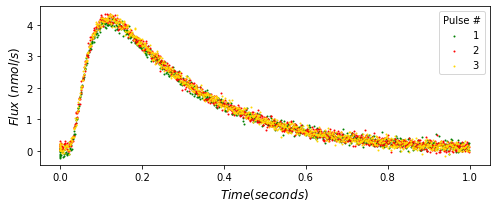

In [30]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(7,3))
ax.set_ylabel(r'$Flux\ (nmol/s)$',fontsize=12)
ax.set_xlabel(r'$Time (seconds)$',fontsize=12)

ax.scatter(new_data['time'][0],new_data['CO'][0],color='g',s=1,label='1')
ax.scatter(new_data['time'][0],new_data['CO'][1],color='r',s=1,label='2')
ax.scatter(new_data['time'][0],new_data['CO'][2],color='gold',s=1,label='3')

ax.legend(title='Pulse #')

plt.tight_layout()
plt.show()

To save time later on, we can store the TAPobject for later use with the command

In [ ]:
save_object(simulation,'./mech_1.json')

Which can be read again and manipulated with

In [ ]:
mech_1 = read_TAPobject('./mech_1.json')

### Now that we've written our first TAPobject, let's apply what we've learned in the 'co_oxidation_problem' notebook

# Optimization and uncertainty specification

Analyzing the inverse problem through optimization and uncertainty quantification are both useful, and often necessary, tools during TAP experiments. To perform optimization, we can define the following:

In [14]:
# Define the new output folder
simulation.output_name = 'o2_fit'

# Define the experimental data object we're fitting to
simulation.data_name = './o2_data/TAP_experimental_data.json'

# Define the gasses to include in our objective function
simulation.gasses_objective = ['CO','O2','CO2']

# Specify the parameters that we want to fit
simulation.parameters_of_interest = ['TAPobject_data.mechanism.elementary_processes[0].forward.k','TAPobject_data.mechanism.elementary_processes[0].backward.k','TAPobject_data.mechanism.elementary_processes[1].forward.k','TAPobject_data.mechanism.elementary_processes[1].backward.k','TAPobject_data.mechanism.elementary_processes[2].forward.k','TAPobject_data.mechanism.elementary_processes[2].backward.k']

# Set the 'optimize' argument to True
simulation.optimize = True

simulation.mechanism.elementary_processes[0].forward.k = 2

# Referencing data without flux_graph
new_data = read_experimental_data_object('./o2_data/TAP_experimental_data.json')
new_data['time'][pulse #]

# Alt optimization routines
opdh_1.optimization_method = 'CG'


# We then just run the forward problem in the same way
# forward_problem(1,5,simulation)

### Since we don't have an experimental data set specified, running the above code will just return an error

We can also calculate the uncertainty around the parameters adjusting the following argument:

In [15]:
simulation.uncertainty = True

It is important to note that the optimization arguments must be put in place before specifying 'TAPobject.uncertainty = True' for the uncertainty analysis to be performed

### Now that we've specified the how to optimize the parameters, do the following:
1. Run the 'o2_adsorption_data_generation' notebook to generate the experimental data set.
2. Solve the 'o2_adsorption_inverse_problem' notebook